<a href="https://colab.research.google.com/github/Varun9213/Blog_machine_learing/blob/main/Augmentaion_blog_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai --upgrade
!pip install pyyaml
!pip install albumentations --upgrade

In [2]:
from fastai import *
from fastai.vision.all import *
from fastai.imports import *
import yaml, cv2, os
from torchvision import transforms as T
from torchvision.transforms import functional as F
import albumentations as A
from matplotlib import patches, text, patheffects

In [3]:
root = Path("/content/data")

In [4]:
os.mkdir(root)
os.chdir(root)

In [ ]:
!curl -L "https://public.roboflow.com/ds/pK9BobmV9A?key=G9IUWXkCZA" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [6]:
train_df = pd.read_csv("https://raw.githubusercontent.com/Varun9213/Blog_machine_learing/main/Data_blog_1/train_fd.csv")
valid_df = pd.read_csv("https://raw.githubusercontent.com/Varun9213/Blog_machine_learing/main/Data_blog_1/valid_fd.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/Varun9213/Blog_machine_learing/main/Data_blog_1/test_fd.csv")
train_df.head()

,name,class,center_x,center_y,width,height
0,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,10.0,0.276367,0.166910,0.058105,0.108601
1,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,7.0,0.443848,0.430029,0.059570,0.139213
2,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,8.0,0.166016,0.305394,0.076172,0.204810
3,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,11.0,0.347168,0.150146,0.062988,0.177843
4,040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.6e3358605c2734735af18f31e571692c,12.0,0.436035,0.340379,0.060059,0.127551


In [8]:
train_images = get_image_files(root/"train")

In [ ]:
def get_target_ds(name, df):
  rows = df[df["name"] == name[:-4]]
  return rows["class"].values, rows[bboxes_cols].values

**Image Plotting Functions**

In [83]:
def get_bb(bboxes, img):

  boxes = bboxes.copy()
  boxes[:,0] = (boxes[:,0] - boxes[:,2]*0.5)*img.shape[1]
  boxes[:,1] = (boxes[:,1] - boxes[:,3]*0.5)*img.shape[0]
  boxes[:,2] = boxes[:,2] * img.shape[1]
  boxes[:,3] = boxes[:,3] * img.shape[0]

  if boxes.shape[0] == 1 : return boxes
  return np.squeeze(boxes)

def img_show(img, ax = None, figsize=(7,11)):
  if ax is None: fig, ax = plt.subplots(figsize=figsize)
  ax.imshow(img)

  return ax

def draw_outline(obj):
  obj.set_path_effects([patheffects.Stroke(linewidth=4, foreground='black'), patheffects.Normal()])

def draw_box(img, ax, bb):
  patch = ax.add_patch(patches.Rectangle((bb[0],bb[1]), bb[2], bb[3], fill=False, edgecolor='red', lw=2))
  draw_outline(patch)

def draw_text(ax, bb, txt, disp):
  text = ax.text(bb[0],(bb[1]-disp),txt,verticalalignment='top',color='white',fontsize=10,weight='bold')
  draw_outline(text)

def plot_sample(img, bboxes, labels, ax=None, figsize=(7,11)):
  bb = get_bb(bboxes, img)
  if ax is None: fig, ax = plt.subplots(figsize=figsize)
  ax = img_show(img, ax=ax)
  for i in range(len(bboxes)):
    draw_box(img,ax,bb[i])
    draw_text(ax, bb[i], str(labels[i]), img.shape[0]*0.05)

def multiplot(dim:tuple, df, images, idxs = None, figsize=(18,10)):
  if idxs is None: idxs = np.random.randint(0, len(images)-1, dim[0]*dim[1])
  fig, ax = plt.subplots(dim[0],dim[1], figsize=figsize)
  plt.subplots_adjust(wspace=0.1, hspace=0)
  fig.tight_layout()
  for i in range(dim[0]):
    for j in range(dim[1]):
      img = images[idxs[(i+1)*j]]
      labels, bboxes = get_target_ds(img.name, df)
      img = cv2.imread(str(img), cv2.IMREAD_UNCHANGED)
      img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
      plot_sample(img, bboxes, labels, ax=ax[i][j])

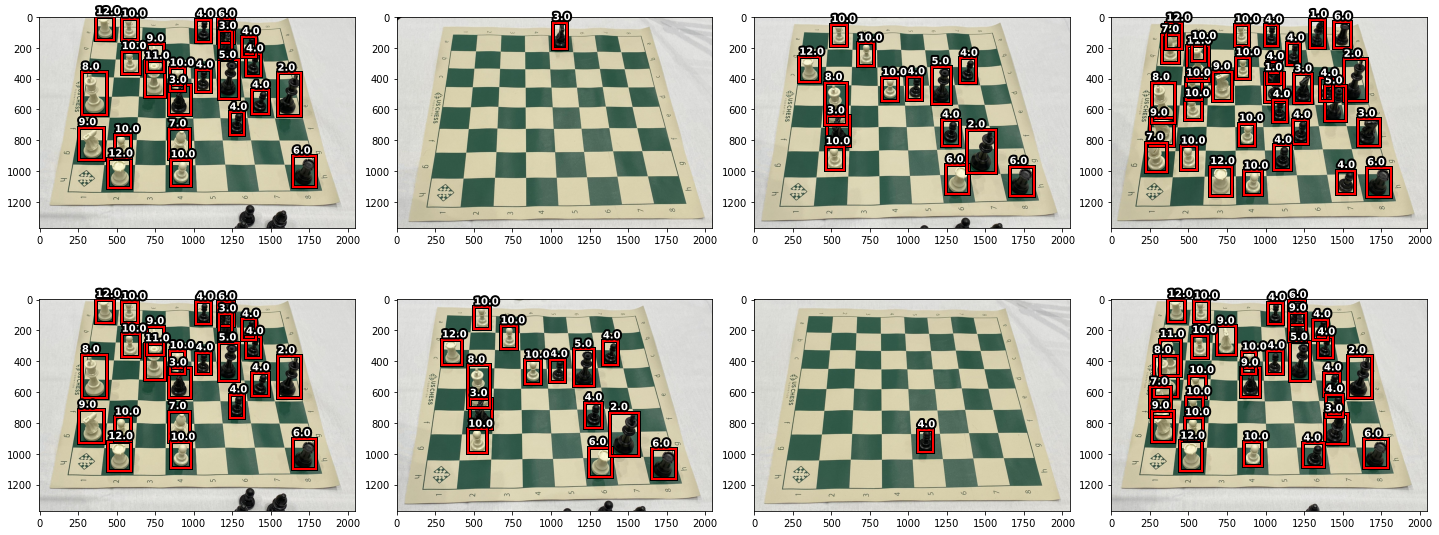

In [85]:
multiplot((2,4), train_df, train_images, figsize=(20,8))

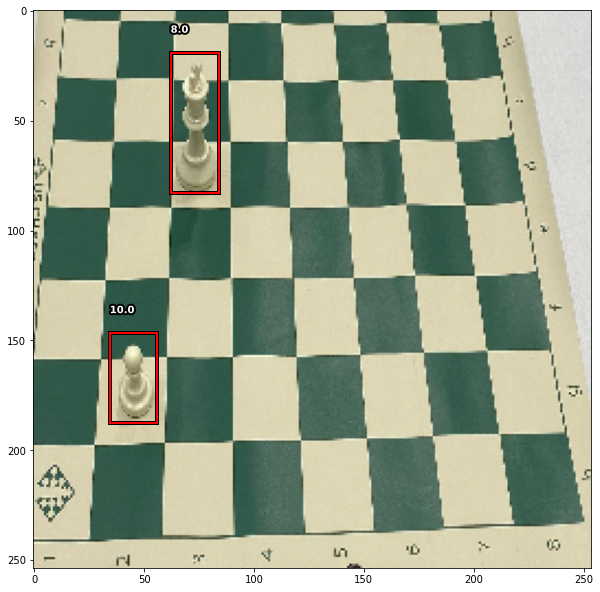

In [ ]:
transforms = A.Compose([A.RandomSizedBBoxSafeCrop(254,254)], bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]))
tr = transforms(image=img, bboxes=boxes, class_labels = labels)
plot_sample(tr["image"], np.array(tr["bboxes"]), tr["class_labels"])

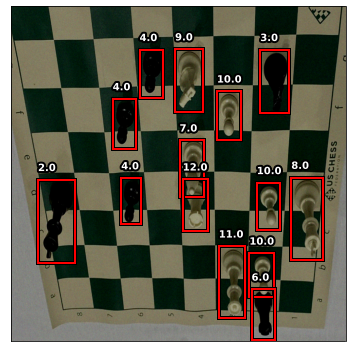

In [ ]:
transforms = A.Compose([A.RandomSizedBBoxSafeCrop(1024,1024), 
                        A.GaussNoise(p=1, var_limit=(75,125)),
                        A.Flip(),
                        A.RandomRotate90(),
                        A.RandomScale(),
                        A.RandomBrightnessContrast()], bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]))
tr = transforms(image=img, bboxes=boxes, class_labels = labels)
plot_sample(tr["image"], np.array(tr["bboxes"]), tr["class_labels"])

In [ ]:
def get_transformations(img, boxes, labels):

  transforms = A.Compose([A.RandomSizedBBoxSafeCrop(1024,1024), 
                          A.GaussNoise(p=1, var_limit=(75,125)),
                          A.Flip(),
                          A.RandomRotate90(),
                          A.RandomScale(),
                          A.RandomBrightnessContrast()], bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]))
  tr = transforms(image=img, bboxes=boxes, class_labels=labels)
  return tr["image"], np.array(tr["bboxes"]), np.array(tr["class_labels"])

In [ ]:


class ChessDataset(torch.utils.data.Dataset):
  
  def __init__(self, images_path, df, get_transformations=None):
    super(ChessDataset, self).__init__()
    self.images_path = images_path
    self.df = df
    self.get_transformations = get_transformations

  def __len__(self):
    return len(self.images_path)

  def __getitem__(self,idx):
    img_path = self.images_path[idx]
    img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    target = {}
    labels, boxes = get_target_ds(img_path.name, self.df)
    if self.get_transformations is not None:
      img, boxes, lables = self.get_transformations(img,boxes,labels)
    areas = boxes[:,2] * boxes[:,3]
    iscrowd = torch.zeros((boxes.shape[0],))
    image_id = torch.tensor([idx])
    labels = torch.as_tensor(labels, dtype=torch.float32)
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    areas = torch.as_tensor(areas, dtype=torch.float32)
    target["boxes"] = boxes
    target["labels"] = labels
    target["areas"] = areas
    target["iscrowd"] = iscrowd
    target["image_id"] = image_id
    img = F.to_tensor(img)

    return img, target

In [ ]:
dataset = ChessDataset(train_images, train_df, get_transformations)
img , target = dataset.__getitem__(1)
size = img.shape
print(img.shape, target["boxes"], target["labels"], target["areas"])

torch.Size([3, 1038, 1038]) tensor([[0.5780, 0.6570, 0.1213, 0.1861]]) tensor([1.]) tensor([0.0226])


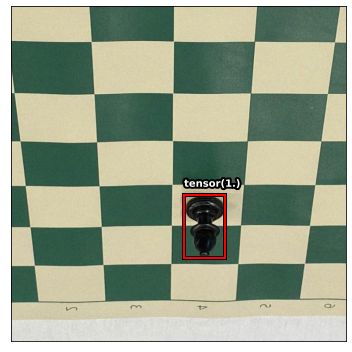

In [ ]:
plot_sample(img.permute(1,2,0), np.array(target["boxes"]), target["labels"])